# Intro
- This is the first jupyter notebook for the EIA interhemispheric assymmetry (IHA) seen during different solar cycles
- TEC comparison during the March equinox is carried out for different years
    - Peaks of the north and south EIA are traced and compared

# Reading New TEC Data and Producing Output Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import os
import datetime as dt
import importlib as il

from p_tqdm import p_map
from multiprocessing import Pool
import itertools

In [3]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 1

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [4]:
functions = il.reload(functions)
month = 'dec' #'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'sept' or month == 'dec':
    years_tot = list(range(2023, 2024))
else:
    years_tot = list(range(2000, 2025))
    
for year in tqdm(years_tot):
    
    print(year)

    
    # Reading Madrigal Cedar data for +- 21 days around March equinox of 2010-2024
    # Files in below scratch folder are obtained by using multiple file download 
    # command in ASCII format and then doing `gunzip file.gz`  
    path = f'{scratch}Qingyu_Cesar_EIA/' + month + '_data/' + str(year) + '_' + month + '_' + phase + '/'
    files = os.listdir(path)
    files = [path + i for i in files]

    for f in files:
        if f[-4:] != '.txt':
            files.remove(f)
            
    print(len(files))
    
    tec_g = []
    columns = ['GDLAT', 'GLON', 'TEC', 'DT']
    grnd_tec = pd.DataFrame(columns=columns)

    def process_file(f):
        # Read function passed continuously during multiple processing to quicken the process
        df = pd.read_csv(f, sep=r'\s+')
        d = [dt.datetime(y, m, d, h, mi, s) for y, m, d, h, mi, s in zip(df.YEAR, df.MONTH, df.DAY, df.HOUR, df.MIN, df.SEC)]
        df['DT'] = d
        # Dropping unnecassary columns from the Dataframe
        df = df.drop(['RECNO', 'KINDAT', 'KINST', 'UT1_UNIX', 'UT2_UNIX', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MIN', 'SEC', 'DTEC'], axis=1)
        if 'GDALT' in df.columns:
            df = df.drop(['GDALT'], axis=1)
        df = df[(df.GDLAT > -60) & (df.GDLAT < 60) & (df.GLON > -85) & (df.GLON < -45)].reset_index(drop=True)
        return df    
    # Speeding the process by using parallel processing
    tec_g = p_map(process_file, files)  # Parallel processing with progress bar
    print('1')
    grnd_tec = pd.concat(tec_g, axis=0).reset_index(drop=True)
    grnd_tec = grnd_tec.sort_values(by=['DT', 'GDLAT'], ascending=[True, True])


    # Reading the Kp index values for all the days and filtering undesired points where Kp > 3
    file = f'{work}Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_{str(year)}_{month}.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    date_kp = [functions.day_to_date(i, year) for i in kp.DOY]
    m, d = zip(*date_kp)
    kp['date'] = [dt.datetime(year, j, i, k, 0, 0) for i,j,k in zip(d,m,kp.Hour)]
    kp['kp'] = [i/10 for i in kp.Kp]
    kp = kp.drop(['Year', 'DOY', 'Hour','Kp'], axis = 1)
    grnd_tec0 = functions.kp_index_filtering(grnd_tec, kp)
    print('2')

    # Calculation of magnetic coordinates by using Apex library and Parallel prcoessing 
    t_start = dt.datetime.now() # just a timer
    with Pool(36) as pool:
        p = pool.starmap(functions.magnetic_coords_parallel, zip(grnd_tec0.DT, grnd_tec0.GDLAT, grnd_tec0.GLON, grnd_tec0.TEC))
    pool.close()
    pool.join()
    # Separating the data from output list 
    sat_date, sat_glat, sat_glon, sat_tec, sat_mlat, sat_mlon, sat_mlt = zip(*p)
    t_total = dt.datetime.now() - t_start
    print(t_total)
    

    # Reordering the outputs and applying further conditions on magnetic coordinates
    grnd_temp = pd.DataFrame({'DT': sat_date, 'GDLAT': sat_glat, 'GLON': sat_glon, 'TEC': sat_tec, 'MLAT': sat_mlat, 'MLON': sat_mlon, 'MLT': sat_mlt})
    grnd_tec1 = grnd_temp.sort_values(by=['DT', 'GDLAT'], ascending=[True, True]).reset_index()
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLON <= 5) & (grnd_tec1.MLON >= -5)].reset_index(drop=True)
    grnd_tec1 = grnd_tec1[(grnd_tec1.MLAT <= 40) & (grnd_tec1.MLAT >= -40)].reset_index(drop=True)
    grnd_tec2 = grnd_tec1.drop(['GDLAT', 'GLON','MLON'], axis = 1)

    
    # Writing the output into csv files for easy post processing
    grnd_tec2.to_csv(f'{scratch}Qingyu_Cesar_EIA/outputs/{month}/{str(year)}_{month}_{phase}.csv', index=False)


  0%|                                                                                                                         | 0/1 [00:00<?, ?it/s]

2023
63


  0%|          | 0/63 [00:00<?, ?it/s]

1
2
0:47:55.986561


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [55:10<00:00, 3310.68s/it]


# F10.7 Comparison for March 2023 and 2024

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt


In [ ]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 1

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220017/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [ ]:
functions = il.reload(functions)
f107_years = [2023, 2024]
month = 'march'

path = f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/f107_{month}_'

columns = ['Year', 'DOY', 'Hour', 'f10_7']
f107 = pd.DataFrame(columns = columns)

for y in f107_years:
    file = f'{path}{str(y)}.txt'
    df_f107 = pd.read_csv(file, sep=r'\s+')
    print(y, 'year -> Mean =', sum(df_f107.f10_7)/len(df_f107.f10_7), 'and Median =', np.median(df_f107.f10_7))
print('\nBoth mean and median of F10.7 index during ' + month + ' equinox for 2023 is higher than 2024.')

2023 year -> Mean = 150.87441860465202 and Median = 148.1
2024 year -> Mean = 146.01395348837212 and Median = 137.6

Both mean and median of F10.7 index during march equinox for 2023 is higher than 2024.


# Reading Data Directly From Saved Output Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
import datetime as dt
from scipy.signal import savgol_filter
import statistics
import seaborn as sns


In [2]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 1

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220016/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

  0%|                                                                                                                        | 0/24 [00:00<?, ?it/s]

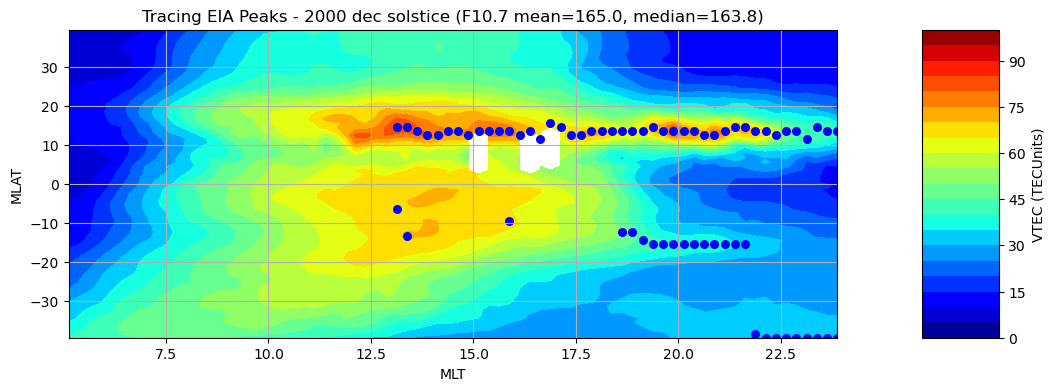

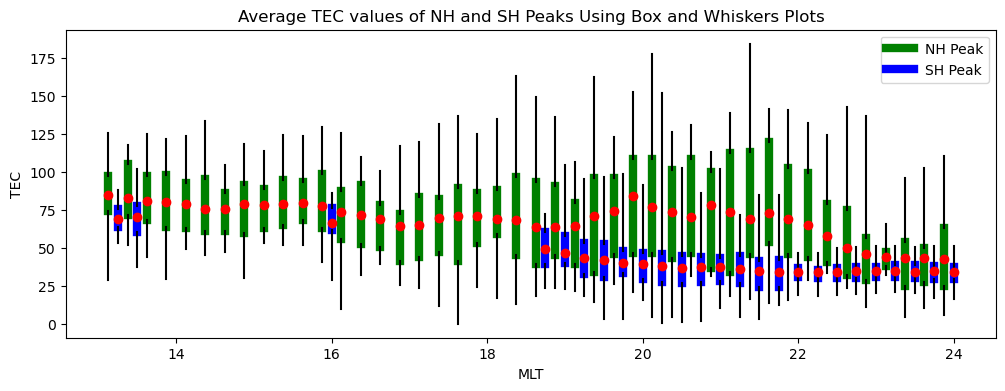

  4%|████▋                                                                                                           | 1/24 [00:09<03:37,  9.47s/it]

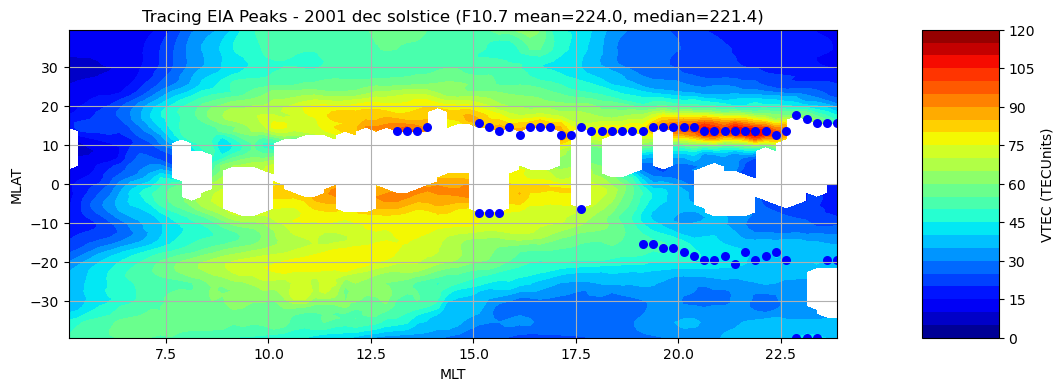

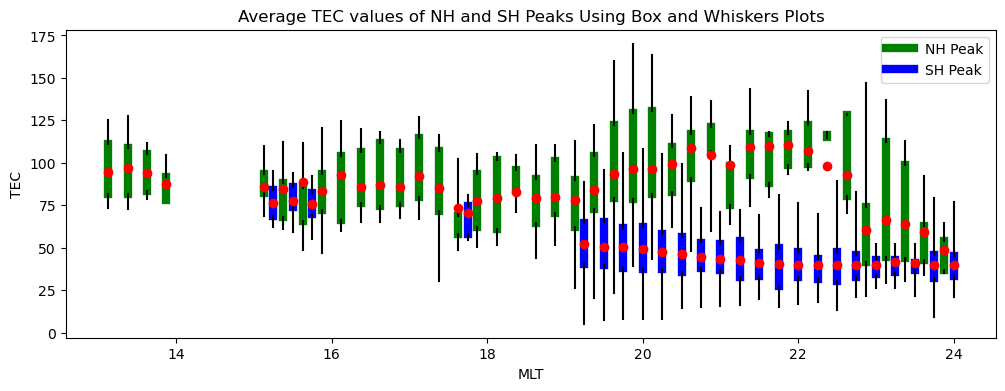

  8%|█████████▎                                                                                                      | 2/24 [00:16<02:52,  7.82s/it]

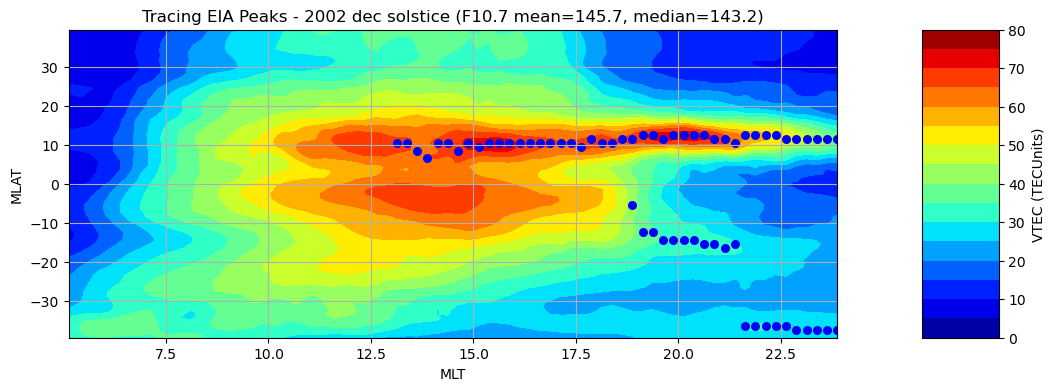

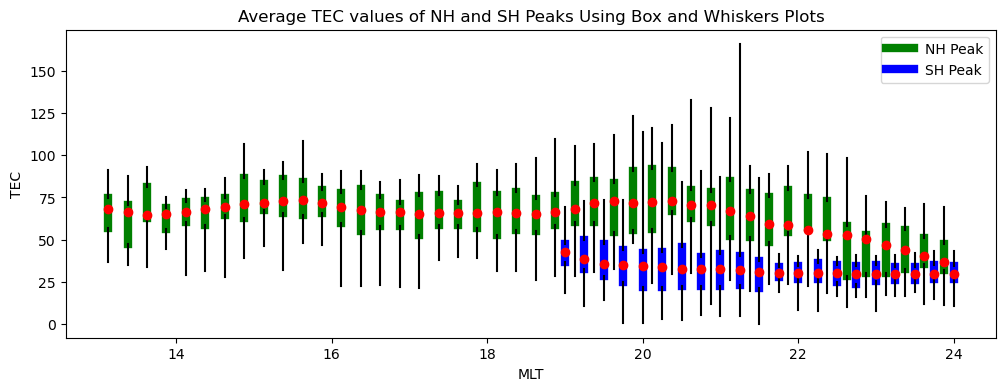

 12%|██████████████                                                                                                  | 3/24 [00:25<02:58,  8.50s/it]

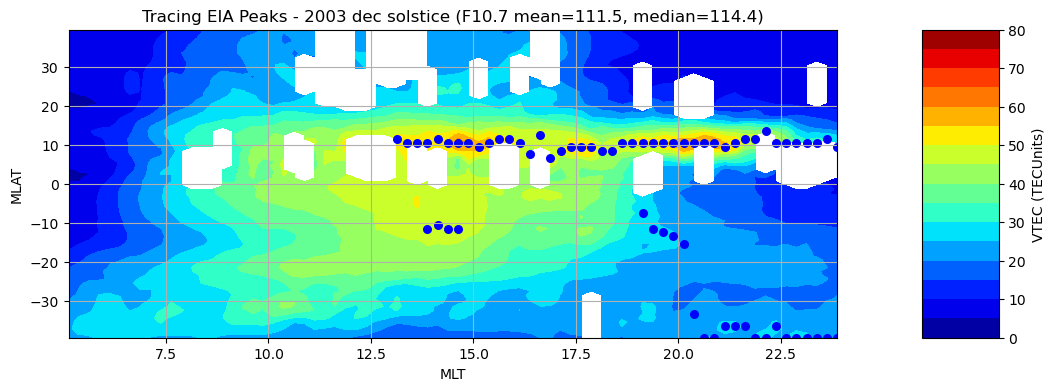

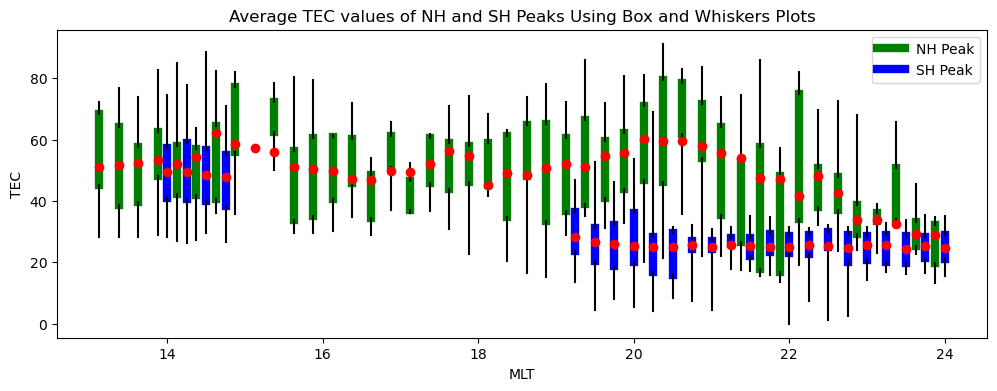

 17%|██████████████████▋                                                                                             | 4/24 [00:32<02:36,  7.82s/it]

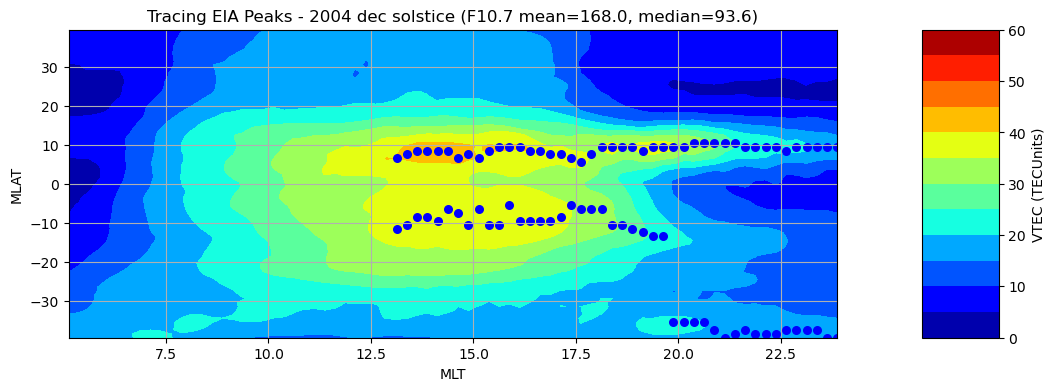

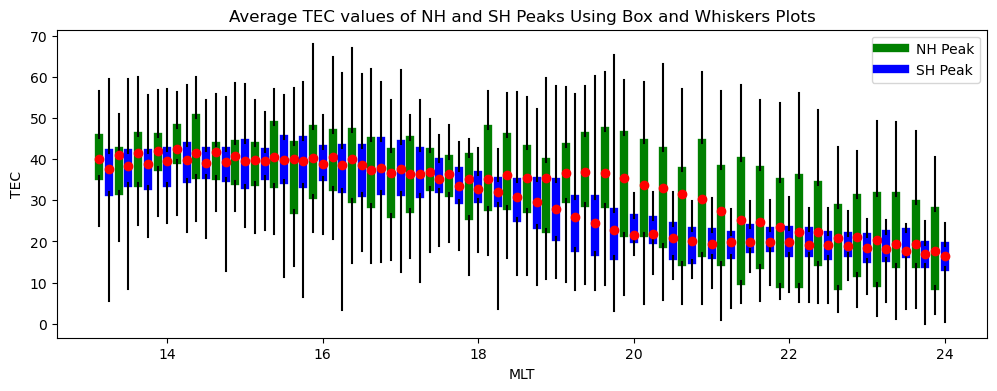

 21%|███████████████████████▎                                                                                        | 5/24 [00:42<02:43,  8.60s/it]

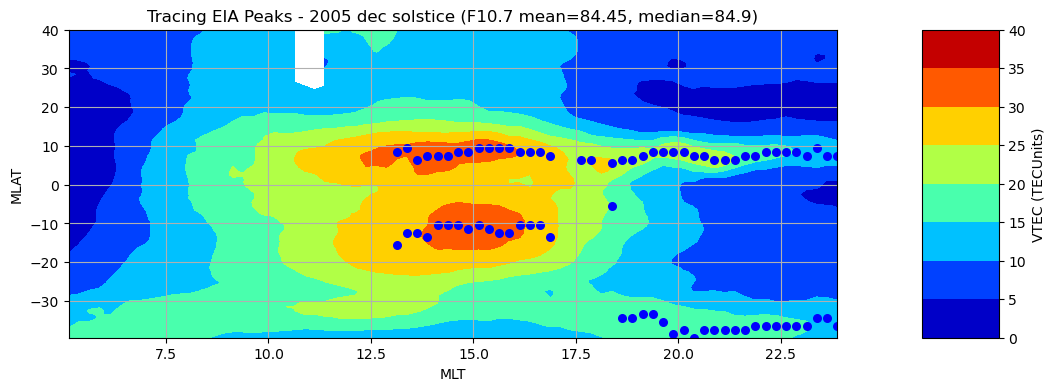

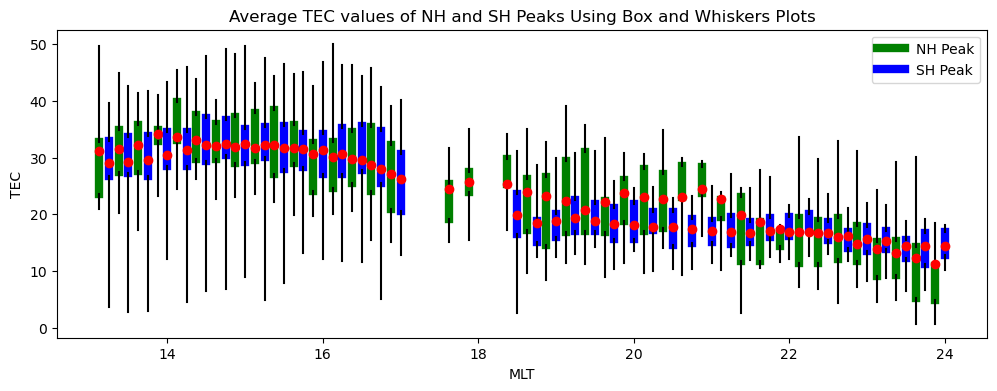

 25%|████████████████████████████                                                                                    | 6/24 [00:50<02:33,  8.52s/it]

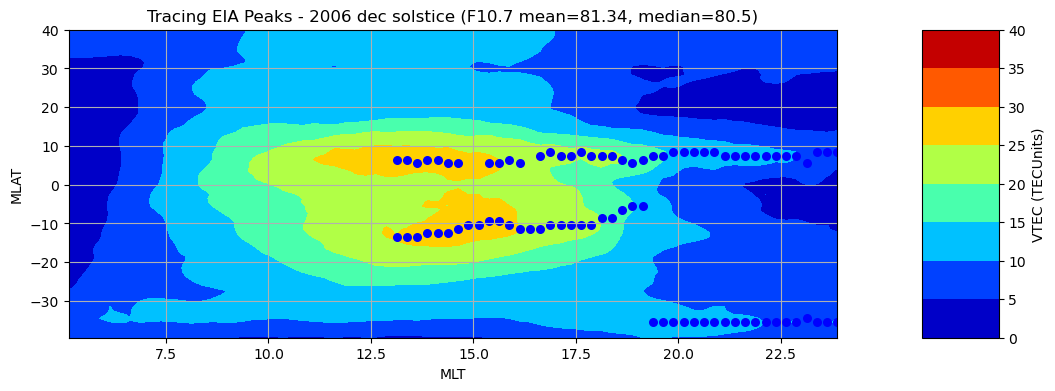

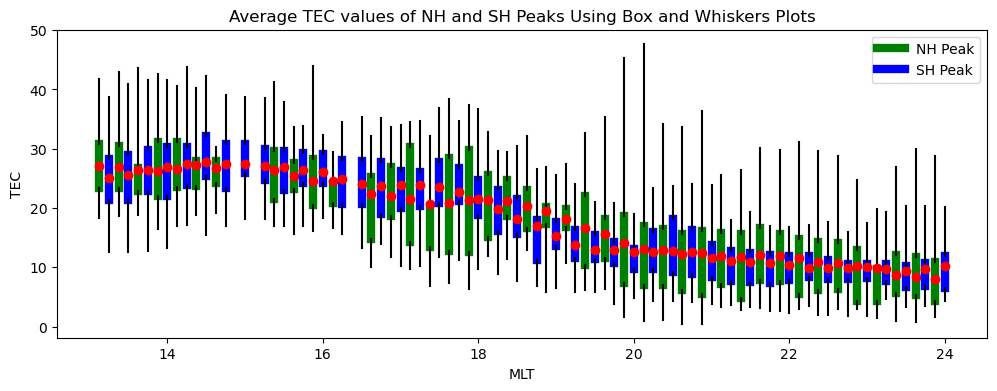

 29%|████████████████████████████████▋                                                                               | 7/24 [01:00<02:34,  9.06s/it]

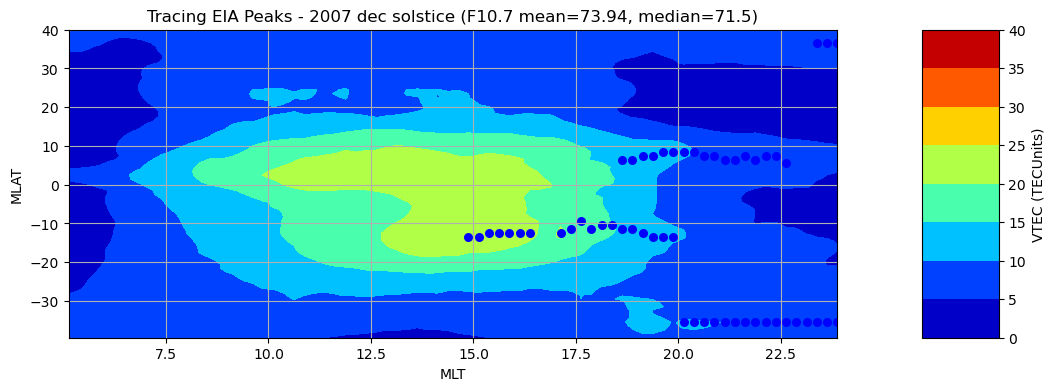

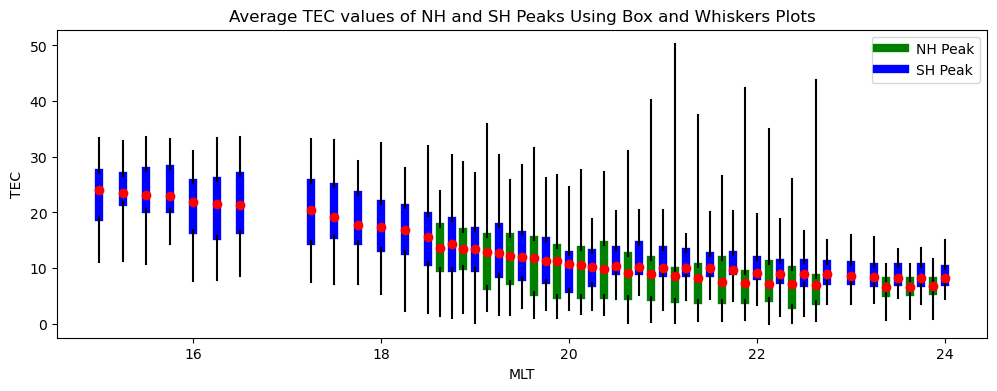

 33%|█████████████████████████████████████▎                                                                          | 8/24 [01:12<02:37,  9.83s/it]

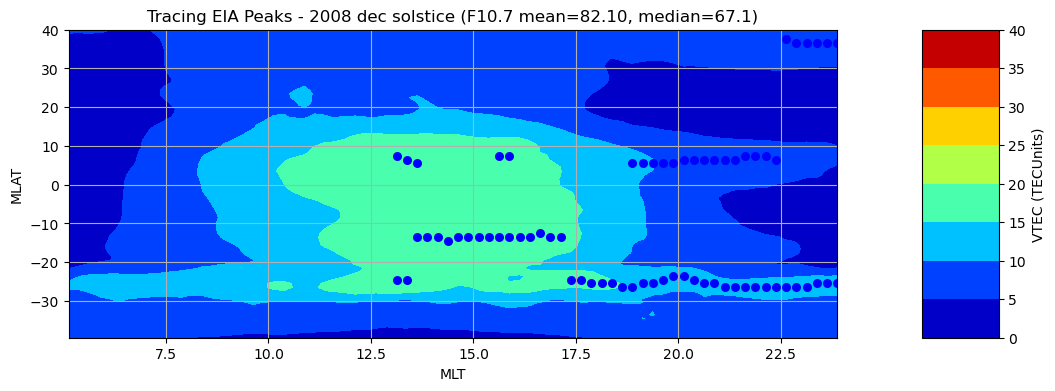

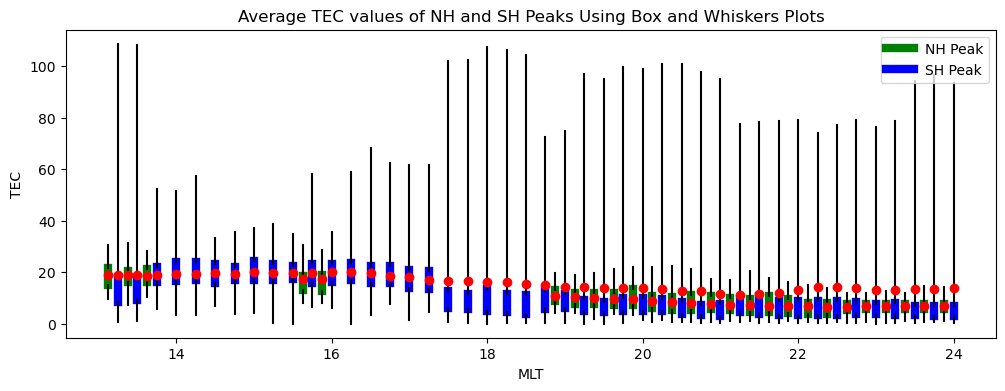

 38%|██████████████████████████████████████████                                                                      | 9/24 [01:25<02:42, 10.81s/it]

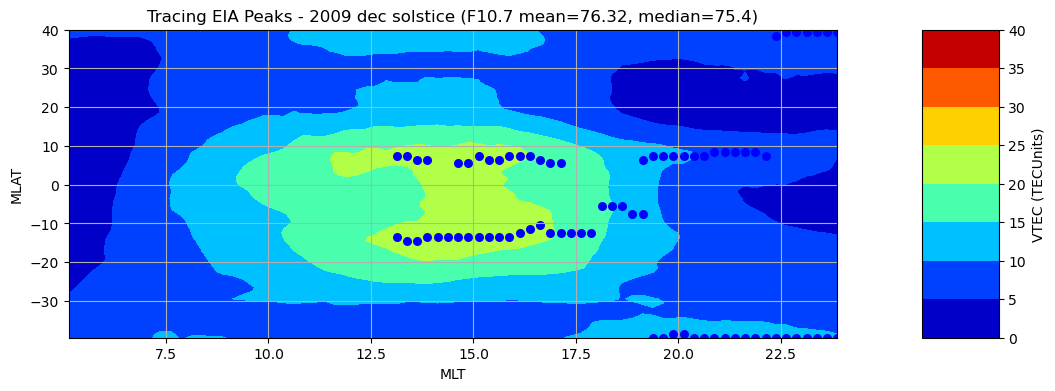

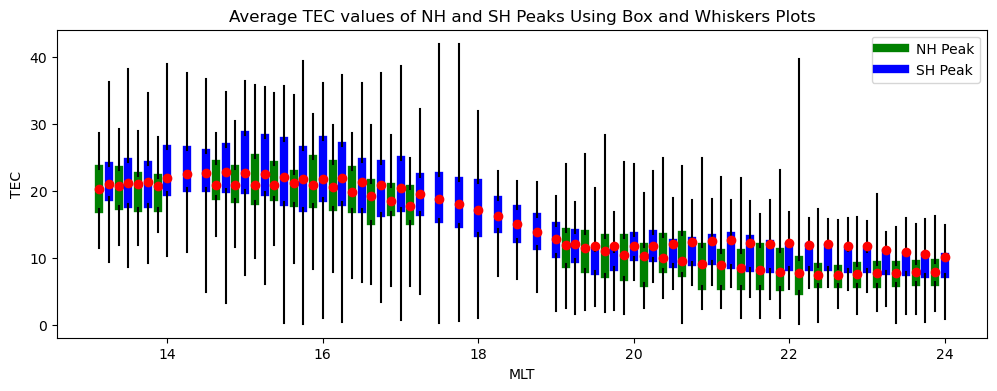

 42%|██████████████████████████████████████████████▎                                                                | 10/24 [01:37<02:39, 11.43s/it]

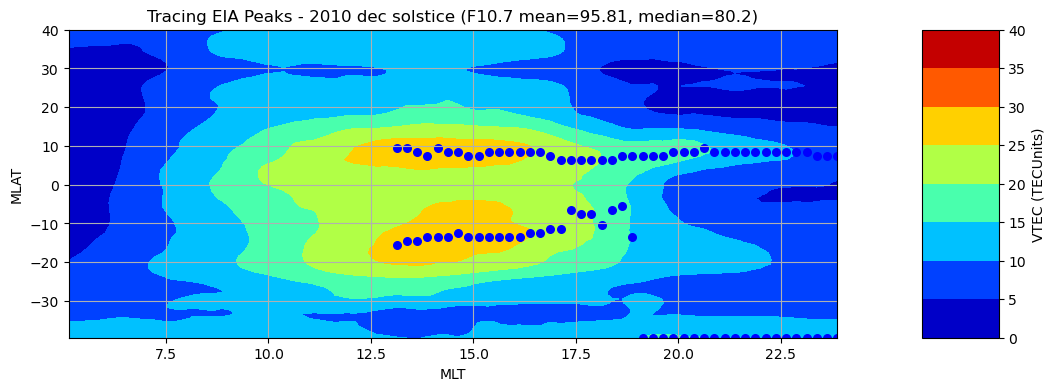

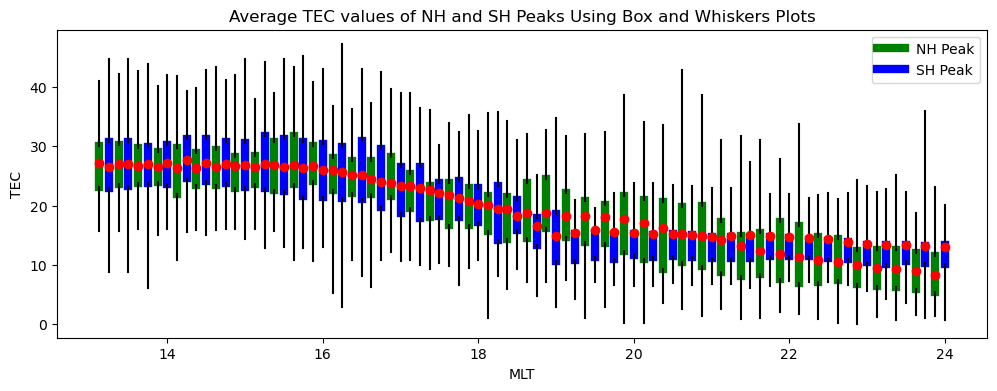

 46%|██████████████████████████████████████████████████▉                                                            | 11/24 [01:53<02:45, 12.71s/it]

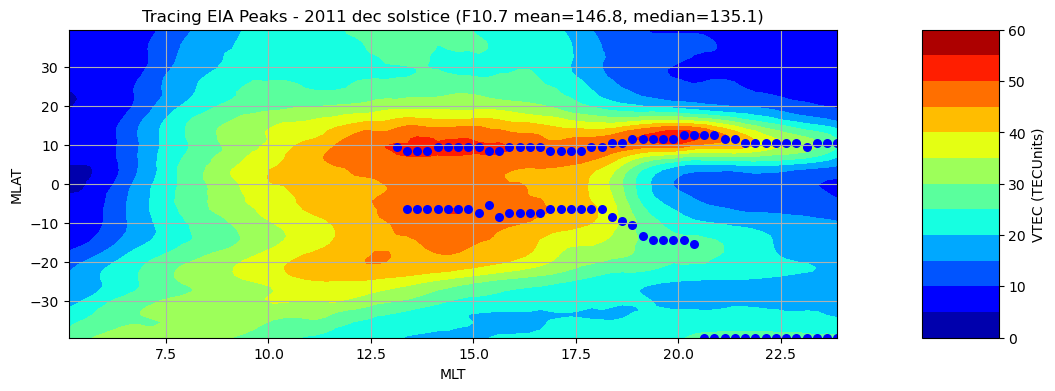

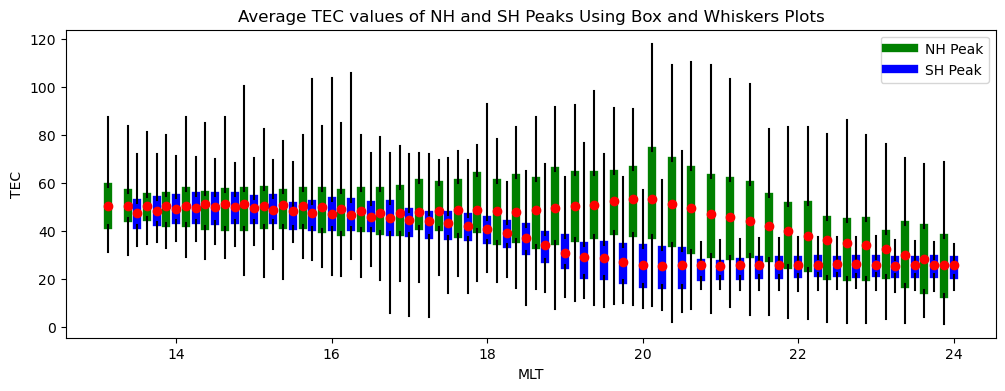

 50%|███████████████████████████████████████████████████████▌                                                       | 12/24 [02:12<02:56, 14.72s/it]

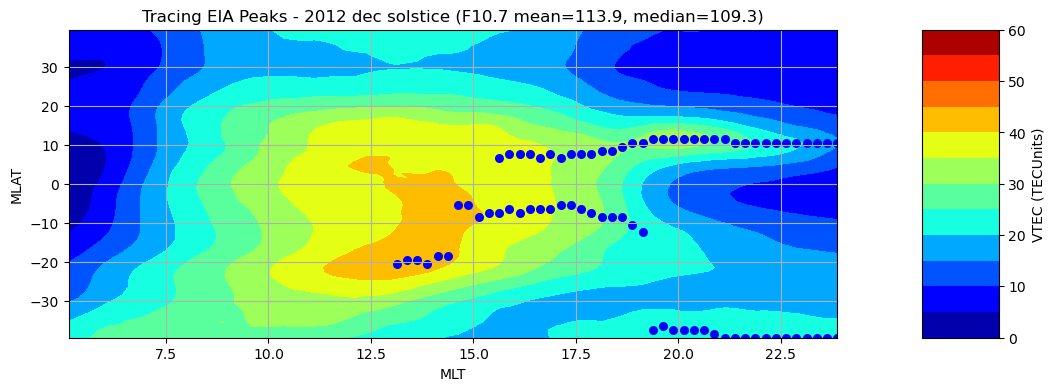

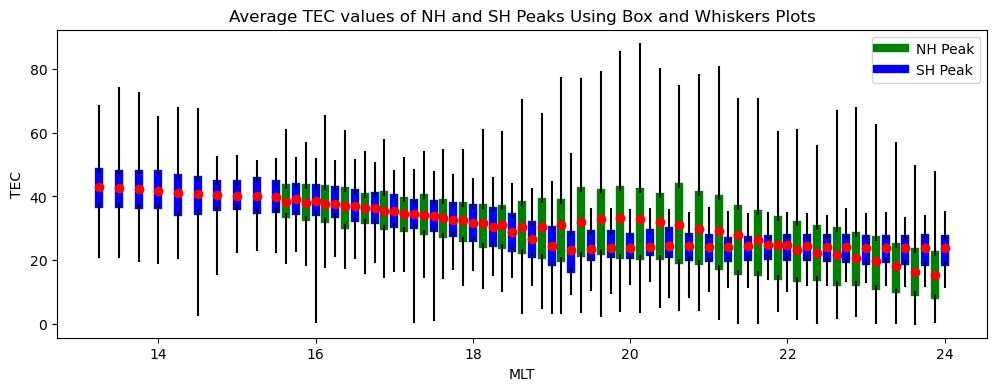

 54%|████████████████████████████████████████████████████████████                                                   | 13/24 [02:41<03:28, 18.94s/it]

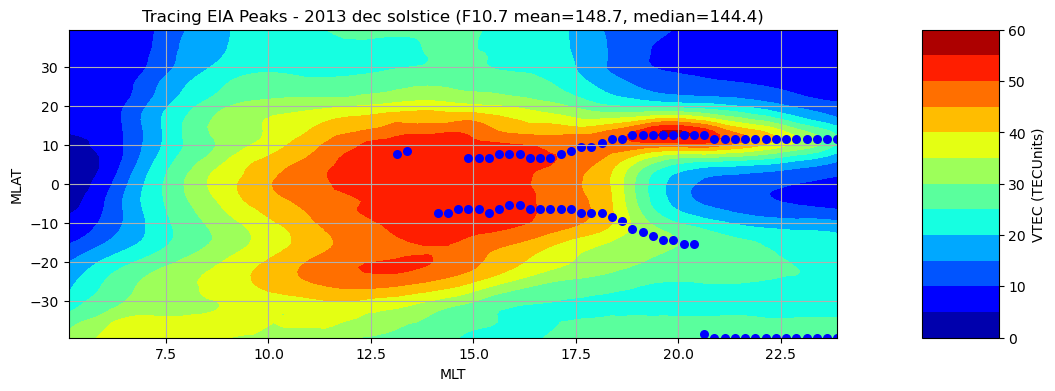

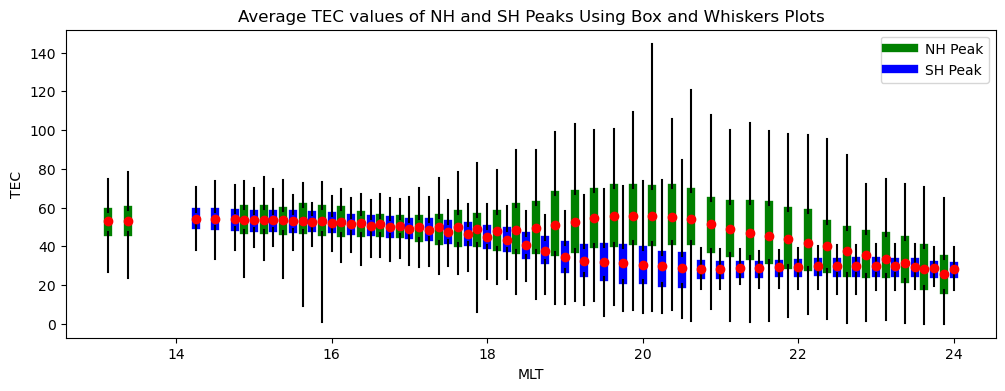

 58%|████████████████████████████████████████████████████████████████▊                                              | 14/24 [03:09<03:36, 21.69s/it]

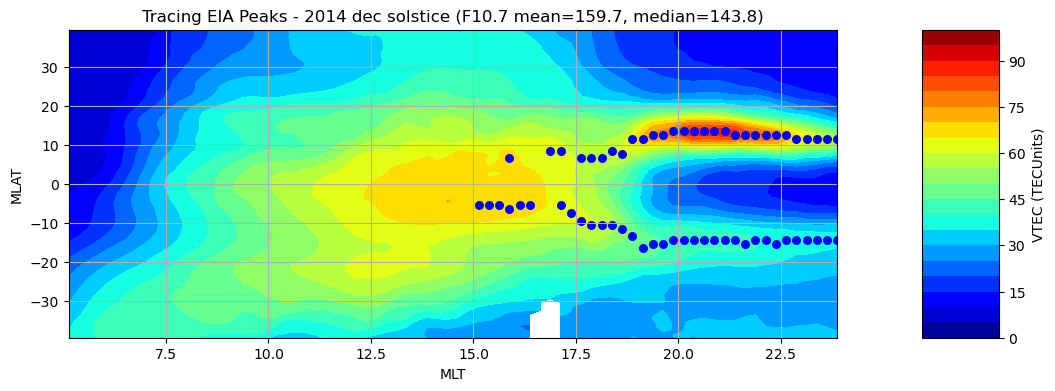

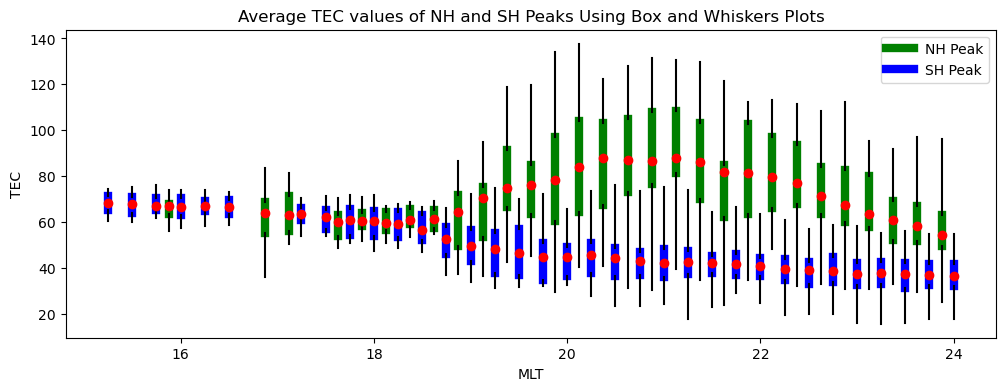

 62%|█████████████████████████████████████████████████████████████████████▍                                         | 15/24 [03:17<02:36, 17.44s/it]

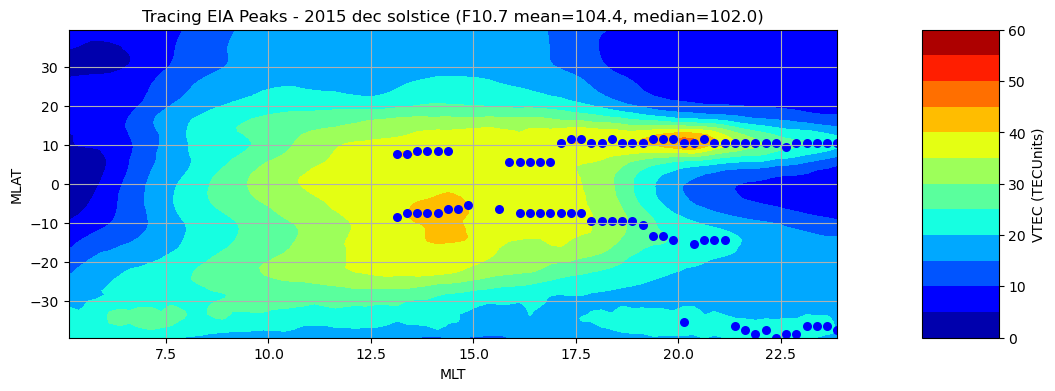

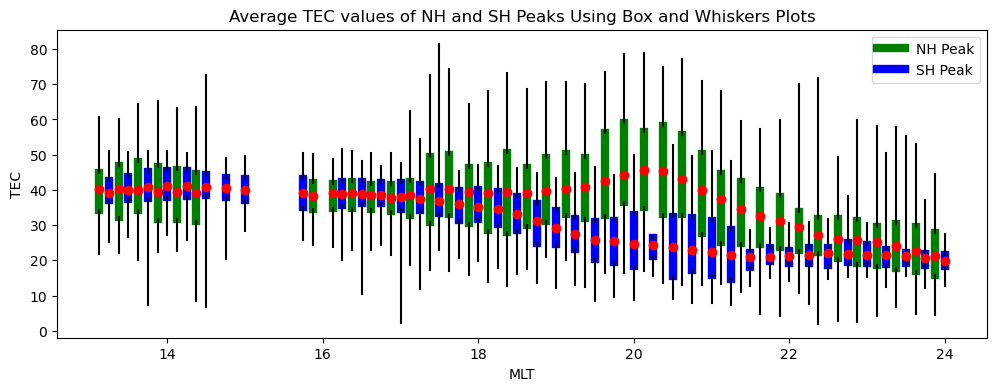

 67%|██████████████████████████████████████████████████████████████████████████                                     | 16/24 [03:30<02:08, 16.07s/it]

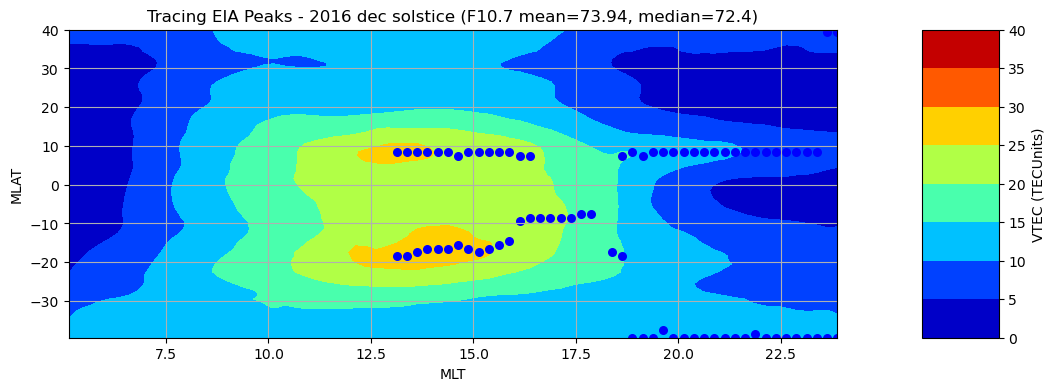

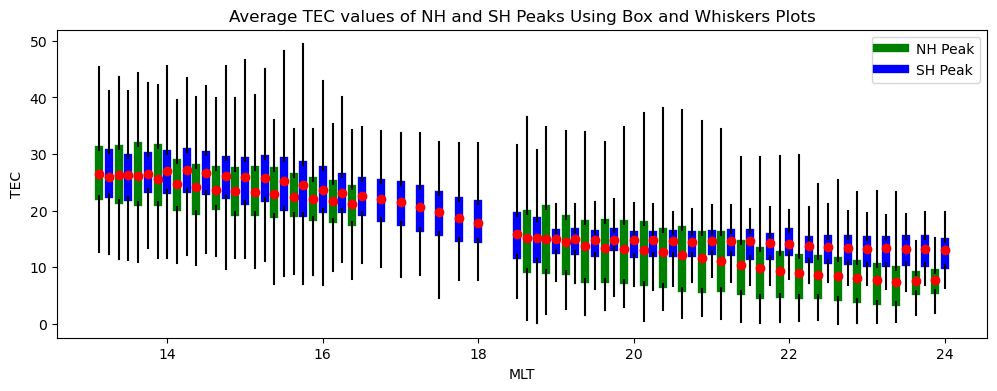

 71%|██████████████████████████████████████████████████████████████████████████████▋                                | 17/24 [03:51<02:03, 17.65s/it]

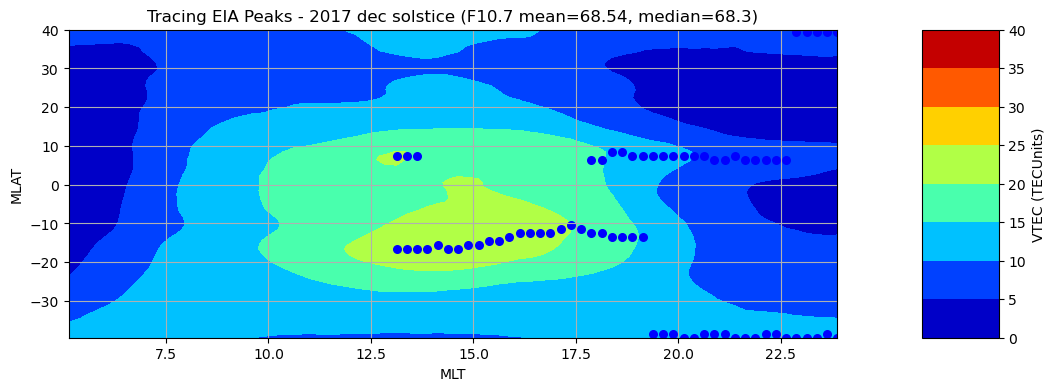

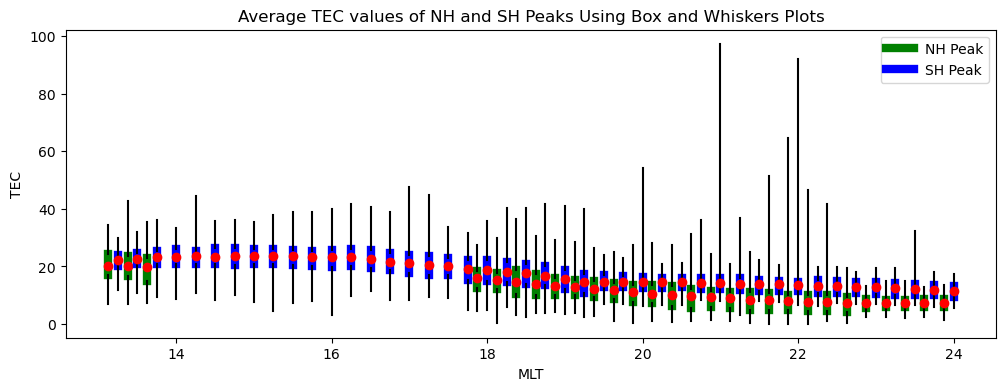

 75%|███████████████████████████████████████████████████████████████████████████████████▎                           | 18/24 [04:17<02:00, 20.07s/it]

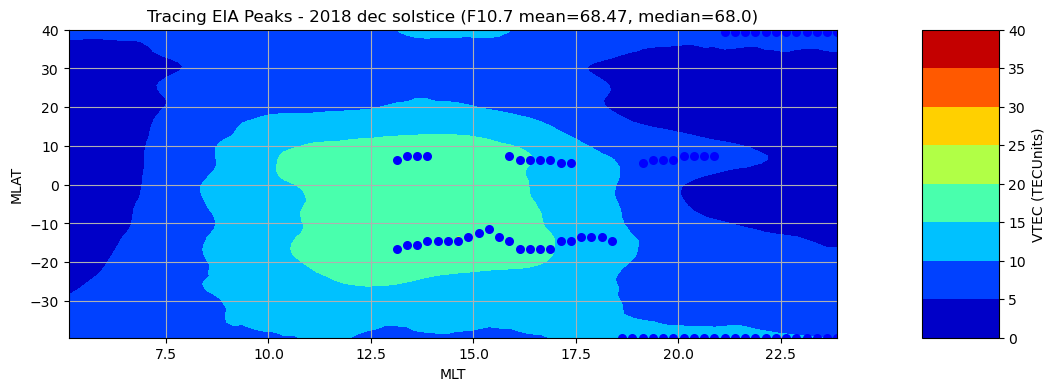

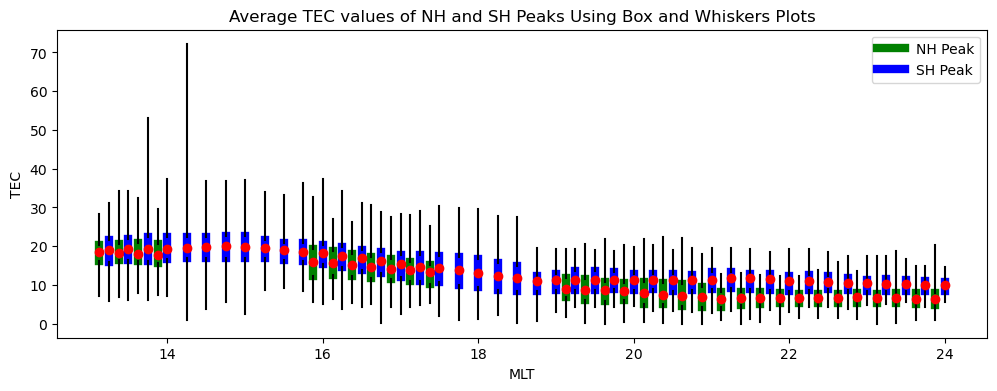

 79%|███████████████████████████████████████████████████████████████████████████████████████▉                       | 19/24 [04:43<01:49, 21.83s/it]

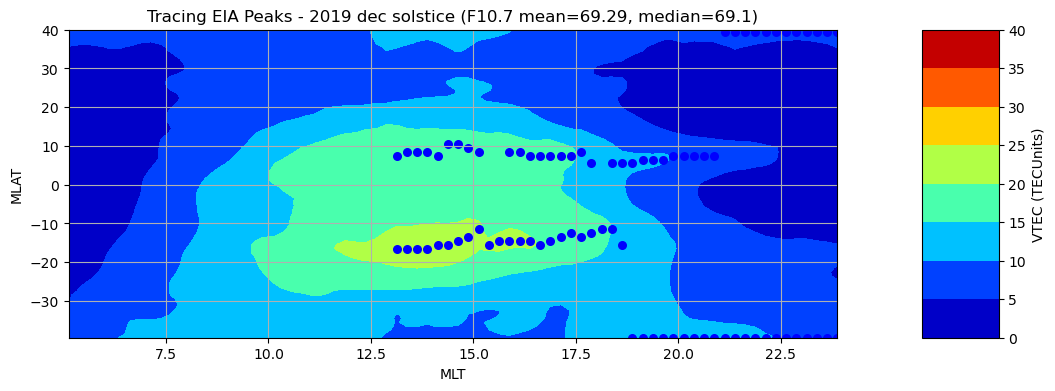

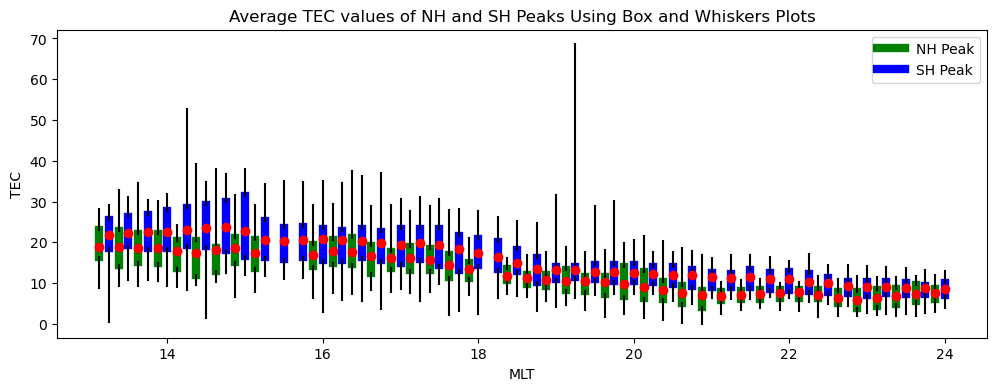

 83%|████████████████████████████████████████████████████████████████████████████████████████████▌                  | 20/24 [04:53<01:13, 18.29s/it]

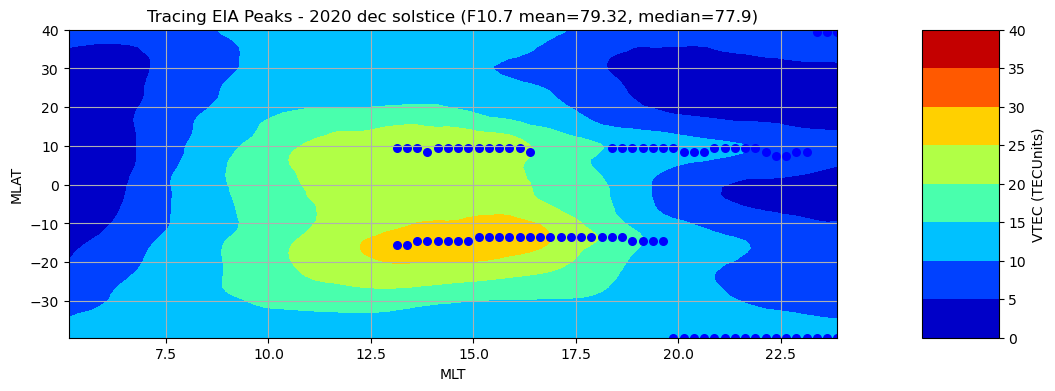

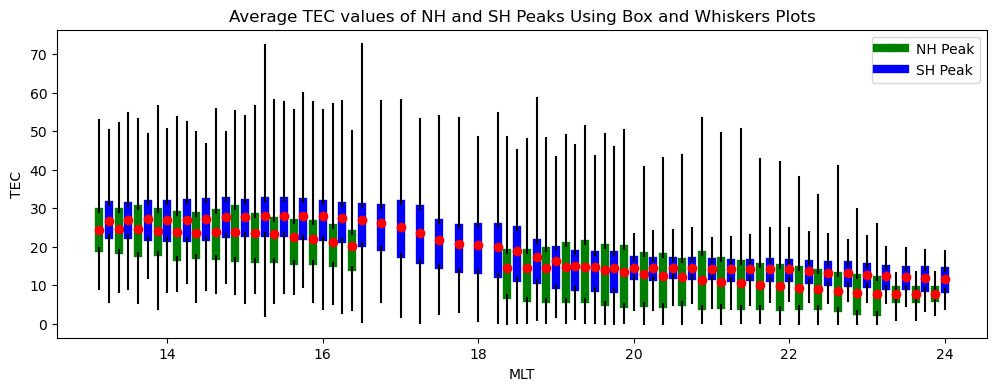

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████▏             | 21/24 [05:26<01:08, 22.79s/it]

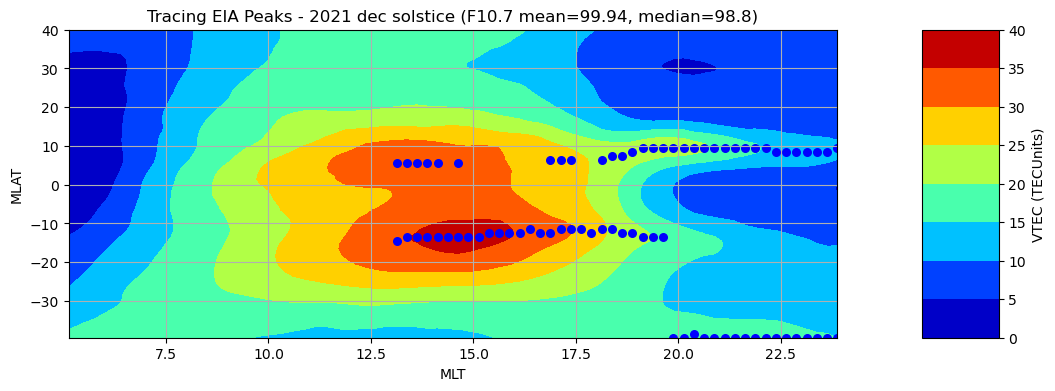

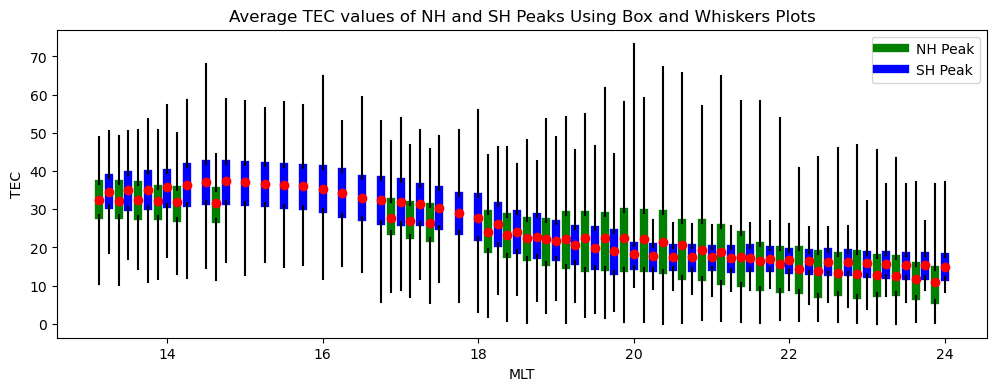

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 22/24 [05:58<00:51, 25.73s/it]

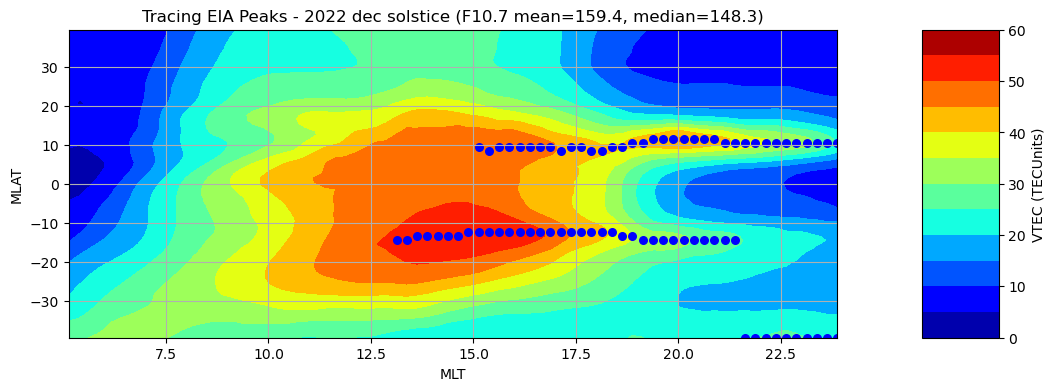

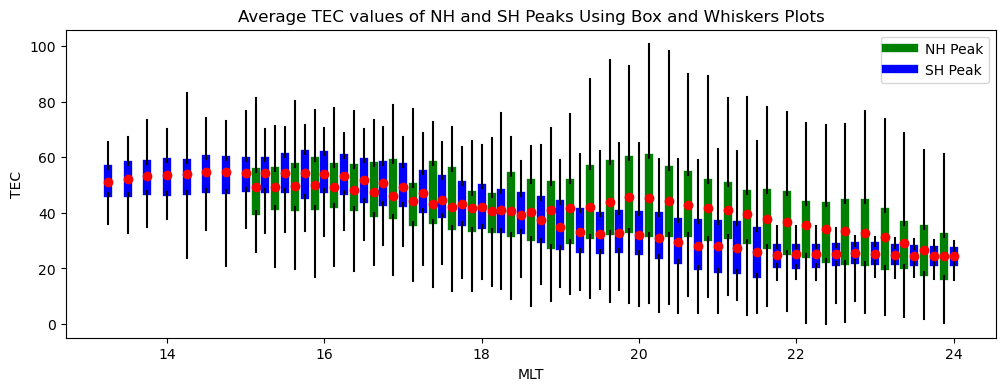

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 23/24 [06:15<00:23, 23.08s/it]

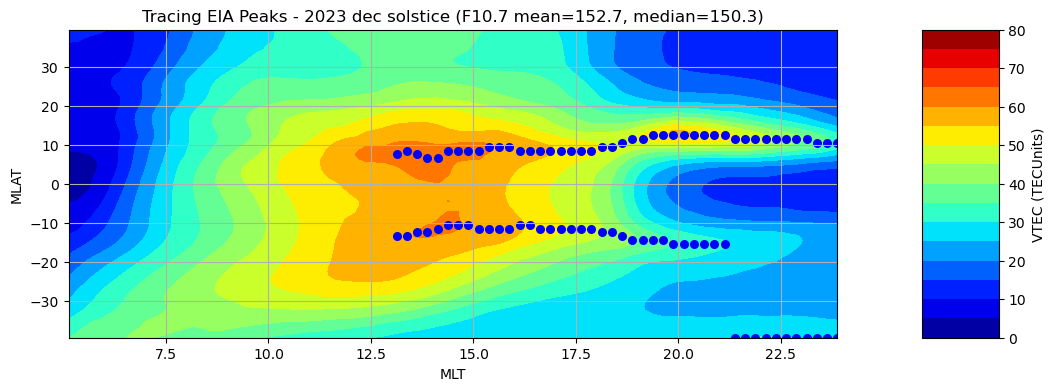

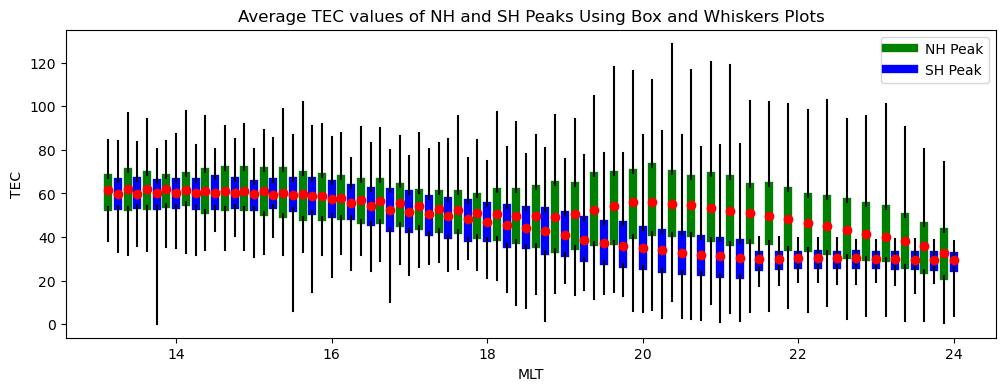

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [06:49<00:00, 17.05s/it]


In [37]:
month = 'dec'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'sept' or month == 'dec':
    years = list(range(2000, 2024))
else:
    years = list(range(2000, 2025))


for year in tqdm(years):
    # Reading the data from output csv
    grnd_tec2 = pd.read_csv(f'{scratch}Qingyu_Cesar_EIA/outputs/{month}/{str(year)}_{month}_{phase}.csv')
    grnd_tec2 = grnd_tec2[grnd_tec2['TEC'] < 250].reset_index(drop=True)


    # Define the bin edges for MLAT and MLT
    bins_mlat = pd.cut(grnd_tec2['MLAT'], bins=pd.interval_range(start=-40, end=40, freq=1))
    bins_mlt = pd.cut(grnd_tec2['MLT'], bins=pd.interval_range(start=0, end=24, freq=0.25))
    
    # Create a new DataFrame with the bins
    grnd_tec2['MLAT_b'] = bins_mlat
    grnd_tec2['MLT_b'] = bins_mlt
    
    # Group by the bins (MLAT_b (primary) and MLT_b (secondary)) and calculate the average of TEC
    grouped = grnd_tec2.groupby(['MLT_b', 'MLAT_b'], observed=False)['TEC']
    result = grouped.agg(mean='mean', std='std', min='min', max='max', q25=(lambda x: x.quantile(0.25)), q75=(lambda x: x.quantile(0.75))).reset_index()
    result = result.rename(columns={'mean':'TEC'})

    # Converting the midpoint values of bins to float and assigning average TEC at those points
    result['MLAT_b'] = result['MLAT_b'].apply(lambda x: x.mid)
    result['MLT_b'] = result['MLT_b'].apply(lambda x: x.mid)
    result['MLAT_b'] = result['MLAT_b'].astype(float)
    result['MLT_b'] = result['MLT_b'].astype(float)


    result = result[result.MLT_b >= 5].reset_index(drop=True)
    
    filtered = []
    for t in result['MLT_b'].unique():
        result_f = result[result['MLT_b'] == t].reset_index(drop=True)
        fit = savgol_filter(np.array(result_f.TEC), 10, 2)
        filtered.extend(fit)
    result['TEC'] = filtered

    result = result.groupby(['MLAT_b', 'MLT_b'], observed=False).sum().reset_index()
    
    
    # Identifying NH and SH peaks
    result_t = result[result.MLT_b >= 13].reset_index(drop=True)
    result_n = result_t[result_t.MLAT_b > 0].reset_index(drop=True)
    result_s = result_t[result_t.MLAT_b < 0].reset_index(drop=True)
    result_n = result_n.loc[result_n.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
    result_s = result_s.loc[result_s.groupby('MLT_b')['TEC'].idxmax()].reset_index(drop=True)
    # Dropping the cases where the SH peak is not prominent and maxima appears to come at equator
    result_n.loc[result_n['MLAT_b'] < 5, 'TEC'] = np.nan
    result_s.loc[result_s['MLAT_b'] > -5, 'TEC'] = np.nan
    #print(result_s)

    i = 100*2*(result_n.TEC - result_s.TEC)/(result_n.TEC + result_s.TEC)
    result_ind = pd.DataFrame({'mlat_n': result_n['MLAT_b'], 'tec_n': result_n['TEC'], 'tec_min_n': result_n['min'], 
                               'tec_max_n': result_n['max'], 'tec_q25_n': result_n['q25'], 'tec_q75_n': result_n['q75'],
                               'tec_std_n': result_n['std'], 'mlat_s': result_s['MLAT_b'], 'tec_s': result_s['TEC'], 
                               'tec_min_s': result_s['min'], 'tec_max_s': result_s['max'], 'tec_q25_s': result_s['q25'], 
                               'tec_q75_s': result_s['q75'], 'tec_std_s': result_n['std'], 'mlt': result_n['MLT_b'], 'asy': i})
    result_ind.to_csv(f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/asy_{str(year)}_{month}.csv', index=False)
    
    X, Y = np.meshgrid(result.MLT_b.unique(), result.MLAT_b.unique())
    Z = result.TEC.values.reshape(X.shape)
    Z = np.ma.masked_where(Z == 0, Z)

    
    if np.max(Z) <= 20:
        contour_levels = list(range(0, 21, 5))
    elif np.max(Z) <= 40:
        contour_levels = list(range(0, 41, 5))
    elif np.max(Z) <= 60:
        contour_levels = list(range(0, 61, 5))
    elif np.max(Z) <= 80:
        contour_levels = list(range(0, 81, 5))
    elif np.max(Z) <= 100:
        contour_levels = list(range(0, 101, 5))
    elif np.max(Z) <= 120:
        contour_levels = list(range(0, 121, 5))
    elif np.max(Z) <= 140:
        contour_levels = list(range(0, 141, 5))
    elif np.max(Z) <= 160:
        contour_levels = list(range(0, 161, 5))

    # Creating new dataframe to remove rows where TEC= NaN
    result_n = pd.DataFrame({'mlt': result_ind.mlt, 'mlat_n': result_ind.mlat_n, 'tec_n': result_ind.tec_n})
    result_n = result_n.dropna(subset='tec_n')
    result_s = pd.DataFrame({'mlt': result_ind.mlt, 'mlat_s': result_ind.mlat_s, 'tec_s': result_ind.tec_s})
    result_s = result_s.dropna(subset='tec_s')

    file = f'{work}Qingyu_Cesar_EIA_IHA/kp3_index_values/kp_{str(year)}_{month}.txt'
    kp = pd.read_csv(file,sep=r'\s+')
    f10_mean = sum(kp['F10.7'])/len(kp['F10.7'])
    f10_med = statistics.median(kp['F10.7'])
    


    # Plotting the TEC plots
    fig = plt.figure(figsize=(12,4))
    specs = fig.add_gridspec(1, 2, width_ratios=[1,0.1])
    ax = []
    ax.append(fig.add_subplot(specs[0, 0]))
    c = ax[0].contourf(X, Y, Z, levels=contour_levels, cmap = 'jet')
    ax[0].scatter(result_n.mlt, result_n.mlat_n, c='b', s=30)
    ax[0].scatter(result_s.mlt, result_s.mlat_s, c='b', s=30)
    ax[0].set_title(f'Tracing EIA Peaks - {str(year)} {month} {phase} (F10.7 mean={str(f10_mean)[:5]}, median={str(f10_med)})')
    ax[0].set_ylabel('MLAT')
    ax[0].set_xlabel('MLT')
    ax[0].grid(True)
    
    # Set ylim conditionally
    if np.max(Z) <= 40:
        ax[0].set_ylim(top=40)

    cbar_ax = fig.add_subplot(specs[0,1])
    cbar = fig.colorbar(c, cax=cbar_ax, label='VTEC (TECUnits)', extend='both')
    fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/eia_peaks/{month}/eia_peaks_{month}_{str(year)}.jpg')
    plt.show()



    # Set ColumnB to NaN where ColumnA is NaN
    result_ind.loc[result_ind['tec_n'].isna(), ['tec_min_n', 'tec_q25_n', 'tec_q75_n', 'tec_max_n']] = np.nan
    result_ind.loc[result_ind['tec_s'].isna(), ['tec_min_s', 'tec_q25_s', 'tec_q75_s', 'tec_max_s']] = np.nan
    
    # Plotting Box and Whiskers plots for Northern and Southern Peaks
    fig = plt.figure(figsize=(12,4))
    for idx, (i, mean, min_val, max_val, q25, q75) in enumerate(zip(result_ind['mlt'], result_ind['tec_n'], result_ind['tec_min_n'], result_ind['tec_max_n'], result_ind['tec_q25_n'], result_ind['tec_q75_n'])):
        # Draw the "box" from 25th percentile to 75th percentile
        plt.plot([i, i], [q25, q75], color='g', label='NH Peak' if idx == 0 else "", lw=6)  # Box line
        # Draw the "whiskers" from min to max
        plt.plot([i, i], [min_val, q25], color='black', lw=1.5)  # Lower whisker
        plt.plot([i, i], [q75, max_val], color='black', lw=1.5)  # Upper whisker
        # Plot the mean as a point
        plt.plot(i, mean, 'ro')  # Mean point
        
    for idx, (i, mean, min_val, max_val, q25, q75) in enumerate(zip(result_ind['mlt'], result_ind['tec_s'], result_ind['tec_min_s'], result_ind['tec_max_s'], result_ind['tec_q25_s'], result_ind['tec_q75_s'])):
        i = i + 0.125
        # Draw the "box" from 25th percentile to 75th percentile
        plt.plot([i, i], [q25, q75], color='b', label='SH Peak' if idx == 0 else "", lw=6)  # Box line
        # Draw the "whiskers" from min to max
        plt.plot([i, i], [min_val, q25], color='black', lw=1.5)  # Lower whisker
        plt.plot([i, i], [q75, max_val], color='black', lw=1.5)  # Upper whisker
        # Plot the mean as a point
        plt.plot(i, mean, 'ro')  # Mean point
    plt.legend()
    plt.title('Average TEC values of NH and SH Peaks Using Box and Whiskers Plots')
    plt.ylabel('TEC')
    plt.xlabel('MLT')
    fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/eia_peaks/{month}/box_plt_{month}_{str(year)}.jpg')
    plt.show()



# Comparing Asymmetry Index

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import cartopy.crs as ccrs
from tqdm import tqdm
from apexpy import Apex
import datetime as dt


In [66]:
# Choose the system: i -> 0:tacc, 1:mac, 2:ganymede
i = 0

if i == 0:
    work = '/work/10028/prasoonv/ls6/repo/sat-interp-tid-analysis/'
    scratch = '/scratch/10028/prasoonv/' 
elif i == 1:
    work = '/Users/prasoonv/repo/sat-interp-tid-analysis/'
    scratch = '/Users/prasoonv/repo/sat-interp-tid-analysis/scratch/'
elif i == 2:
    work = '/home/pxv220016/prasoon/data/sat_interp_repo/sat-interp-tid-analysis/'
    scratch = '/home/pxv220017/scratch/'

import sys
sys.path.append('')
sys.path.append(f'{work}prasoon_utility_programs')
sys.path.append(f'{work}Qingyu_Cesar_EIA_IHA')
import functions

In [79]:
month = 'sept' # 'march'

if month == 'sept' or month == 'march':
    phase = 'equinox'
else:
    phase = 'solstice'

if month == 'sept' or month == 'dec':
    years = list(range(2006, 2009)) + list(range(2017, 2020)) + list(range(2000, 2003)) + list(range(2012, 2015)) + list(range(2022, 2024))
else:
    years = list(range(2006, 2009)) + list(range(2017, 2020)) + list(range(2000, 2003)) + list(range(2012, 2015)) + list(range(2022, 2025))


asy_ind = []

for y in years:
    f = pd.read_csv(f'{work}Qingyu_Cesar_EIA_IHA/outputs/{month}/asy_{str(y)}_{month}.csv')
    asy_ind.append(f)

In [82]:
if month == 'sept' or month == 'dec':
    solar_cyc = [[list(range(2006, 2009))], [list(range(2017, 2020))], [list(range(2000, 2003))], [list(range(2012, 2015))], [list(range(2022, 2024))]]
else:
    solar_cyc = [[list(range(2006, 2009))], [list(range(2017, 2020))], [list(range(2000, 2003))], [list(range(2012, 2015))], [list(range(2022, 2025))]]


sc = ['Baseline Min-SC24', 'Baseline Min-SC25', 'Baseline Max-SC23', 'Baseline Max-SC24', 'Baseline Max-SC25']

sc_base = []

for s, n in tqdm(zip(solar_cyc, sc)):

    fig = plt.figure(figsize=(12,8))

    for periods in s:
        columns = ['mlt', 'asy']
        baseline = pd.DataFrame(columns=columns)

        for p in periods:
            a = pd.read_csv(f'{work}/Qingyu_Cesar_EIA_IHA/outputs/{month}/asy_{str(p)}_{month}.csv')
            a = a.drop(['mlat_n', 'mlat_s', 'tec_n', 'tec_s'], axis=1)
            #a = a.dropna(subset = 'asy')
            baseline = pd.concat([baseline, a], axis=0).reset_index(drop=True)
            plt.plot(a.mlt, a.asy, linestyle = '--', label = f'{str(p)} ASY Index')
        
        baseline = baseline.sort_values(by=['mlt'], ascending=[True])
        bins_mlt = pd.cut(baseline['mlt'], bins=pd.interval_range(start=0, end=24, freq=0.75))
        baseline['mlt'] = bins_mlt
        baseline = baseline.groupby(['mlt'])['asy'].mean().reset_index()
        baseline['mlt'] = baseline['mlt'].apply(lambda x: x.mid)
        baseline['mlt'] = baseline['mlt'].astype(float)
        baseline.dropna(inplace=True)
        plt.plot(baseline.mlt, baseline.asy, label=n, linewidth=3)
        print(baseline)
        break
    
    plt.ylim(-30,30)
    plt.axhline(y=0, color='red', linestyle='-.')
    plt.legend()
    plt.title('Asymmetry Index of the EIA Peak Magnitude')
    plt.ylabel('ASY index (%)')
    plt.xlabel('MLT (Hours)')
    plt.grid(True)
    fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/{n[-8:]}_{month}.jpg')
    plt.show()
    
    sc_base.append(baseline)


0it [00:00, ?it/s]

1it [00:00,  8.49it/s]

       mlt        asy
17  13.125  10.049760
18  13.875  12.249435
19  14.625  14.796540
20  15.375  17.752089
21  16.125  24.421050
22  16.875  20.274114
23  17.625  17.108996
24  18.375  13.252168
25  19.125  15.143293
26  19.875  15.853694
27  20.625  11.348634
28  21.375   8.329782
29  22.125   2.081856
30  22.875   2.258801
31  23.625   5.583339
       mlt        asy
17  13.125   8.479868
18  13.875  10.515567
19  14.625  10.997735
20  15.375   7.892180
21  16.125  10.431859
22  16.875   8.658075
23  17.625   5.751419
24  18.375   5.070644
25  19.125   2.191652
26  19.875  -0.360423
27  20.625   1.415835
28  21.375   2.781555
29  22.125   3.721693
30  22.875  13.217005
       mlt        asy
17  13.125  29.133674
18  13.875  19.527010
19  14.625  20.239348
20  15.375  10.738350
21  16.125   8.943128
22  16.875   8.630654
23  17.625   9.123485
24  18.375   6.940371
25  19.125   6.167420
26  19.875   9.607993
27  20.625  13.868344
28  21.375  19.595431
29  22.125   8.849994
30  22.875

5it [00:00, 10.91it/s]

       mlt        asy
18  13.875  16.964922
19  14.625  18.024702
20  15.375  15.171170
21  16.125  12.841654
22  16.875  11.117760
23  17.625   9.822784
24  18.375   9.736567
25  19.125  11.005506
26  19.875   7.454038
27  20.625  10.454204
28  21.375  14.346315
29  22.125  12.253934
30  22.875  10.443778
31  23.625   1.812995
       mlt        asy
17  13.125  14.942398
18  13.875  15.236616
19  14.625  10.346091
20  15.375   5.622188
21  16.125   3.886455
22  16.875   1.271233
23  17.625  -3.845755
24  18.375  -8.823941
25  19.125 -19.050625
26  19.875 -15.238486
27  20.625  -8.697833
28  21.375  -7.468606
29  22.125  -7.751640
30  22.875  -4.070954
31  23.625 -10.848854


In [83]:
color = ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
marker = ['o', 'x', 'D', 's']


# Solar maxima EIAs
fig = plt.figure(figsize=(12,8))
for s, name in zip(sc_base[3:], sc[3:]):
    plt.plot(s.mlt, s.asy, label=name, linewidth=3)
n = 0

for a, y in zip(asy_ind[9:], years[9:]):
    plt.plot(a.mlt, a.asy, linestyle = '--', c = color[n])
    if y < 2011:
        m = marker[0]
    elif y < 2021:
        m = marker[1]
    else:
        m = marker[2]
    plt.scatter(a.mlt, a.asy, marker = m, c = color[n], label=f'{str(y)} ASY Index', s=50)
    n = n + 1

plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlim(13,22)
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/asy_all_MAX_{month}.jpg')
fig.show()

# Solar minima EIAs
fig = plt.figure(figsize=(12,8))
for s, name in zip(sc_base[:2], sc[:2]):
    plt.plot(s.mlt, s.asy, label=name, linewidth=3)
n = 0

for a, y in zip(asy_ind[:6], years[:6]):
    plt.plot(a.mlt, a.asy, linestyle = '--', c = color[n])
    if y < 2011:
        m = marker[0]
    elif y < 2021:
        m = marker[1]
    else:
        m = marker[2]
    plt.scatter(a.mlt, a.asy, marker = m, c = color[n], label=str(y) + ' ASY Index', s=50)
    n = n + 1

plt.ylim(-30,30)
plt.axhline(y=0, color='red', linestyle='-.')
plt.legend()
plt.title('Asymmetry Index of the EIA Peak Magnitude')
plt.ylabel('ASY index (%)')
plt.xlim(13,22)
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/asy_all_MIN_{month}.jpg')
plt.show()



In [84]:
color = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

# Solar Max Peak Locations
n = 0
fig = plt.figure(figsize=(12,8))
for a, y in zip(asy_ind[6:], years[6:]):
    a_n = a[a.mlat_n > 8].reset_index(drop=True)
    a_s = a[a.mlat_s < -8].reset_index(drop=True)
    if y < 2003:
        mlat = list(a_s.mlat_s)
        time = list(a_s.mlt)
    else:
        mlat = list(a_n.mlat_n) + list(a_s.mlat_s)
        time = list(a_n.mlt) + list(a_s.mlt)
        plt.plot(list(a_n.mlt), list(a_n.mlat_n), c=color[n])
    plt.scatter(time, mlat, c=color[n], label = str(y))
    plt.plot(list(a_s.mlt), list(a_s.mlat_s), c=color[n])
    n = n+1
    
if month == 'june' or month == 'dec':
    plt.ylim(-15,30)
else:
    plt.ylim(-20,20)
plt.xlim(13,22)
plt.legend()
plt.title('Position of NH SH Peaks During Solar Maximas')
plt.ylabel('MLAT')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/pos_all_MAX_{month}.jpg')
fig.show()


# Solar Min Peak Locations
fig = plt.figure(figsize=(12,8))
n = 0
for a, y in zip(asy_ind[:6], years[:6]):
    a_n = a[a.mlat_n > 8].reset_index(drop=True)
    a_s = a[a.mlat_s < -8].reset_index(drop=True)
    if y < 2003:
        mlat = list(a_s.mlat_s)
        time = list(a_s.mlt)
    else:
        mlat = list(a_n.mlat_n) + list(a_s.mlat_s)
        time = list(a_n.mlt) + list(a_s.mlt)
        plt.plot(list(a_s.mlt), list(a_s.mlat_s), c=color[n])
    plt.scatter(time, mlat, c = color[n], label=str(y))
    plt.plot(list(a_n.mlt), list(a_n.mlat_n), c=color[n])
    n = n + 1

if month == 'june' or month == 'dec':
    plt.ylim(-20, 30)
else:
    plt.ylim(-15,15)
plt.xlim(13,20)
plt.legend()
plt.title('Position of NH SH Peaks During Solar Minimas')
plt.ylabel('MLAT')
plt.xlabel('MLT (Hours)')
plt.grid(True)
fig.savefig(f'{work}Qingyu_Cesar_EIA_IHA/outputs/asy_ind/{month}/pos_all_MIN_{month}.jpg')
plt.show()
